In [1]:
import anndata
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd

from scbasset.utils import *

In [3]:
# see ig GPU is available
tf.config.list_physical_devices('GPU')

2023-10-24 16:16:30.153434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 16:16:31.761894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 16:16:31.762768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
ad_file = '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/atac_ad.h5ad'
trained_model = '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/model/best_model.h5'
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/eval"

In [8]:
# Make output directory if it doesn't exist
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [4]:
# read h5ad file
ad = anndata.read_h5ad(ad_file)

# load model
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights(trained_model)

2023-10-24 16:16:33.480548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 16:16:33.481116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 16:16:33.481998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 16:16:33.482806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

/cellar/users/aklie/opt/miniconda3/envs/scbasset/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Pearson R: 0.959')

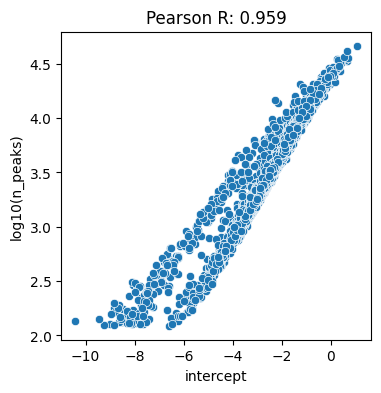

In [5]:
intercept = get_intercept(model) # get_intercept function
sc.pp.filter_cells(ad, min_counts=0)

f, ax = plt.subplots(figsize=(4,4))
r = scipy.stats.pearsonr(intercept, np.log10(ad.obs['n_genes']))[0]
sns.scatterplot(intercept, np.log10(ad.obs['n_genes']), ax=ax)
ax.set_xlabel('intercept')
ax.set_ylabel('log10(n_peaks)')
ax.set_title('Pearson R: %.3f'%r)

In [9]:
proj = get_cell_embedding(model) # get_cell_embedding function
pd.DataFrame(proj).to_csv(os.path.join(outdir_path, 'projection_atac.csv'))

/cellar/users/aklie/opt/miniconda3/envs/scbasset/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


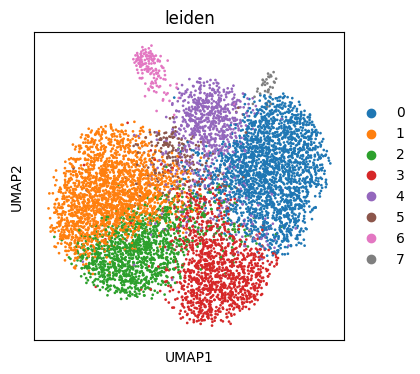

In [10]:
f, ax = plt.subplots(figsize=(4, 4))
ad.obsm['projection'] = pd.read_csv(os.path.join(outdir_path, 'projection_atac.csv'), index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.umap(ad)
sc.tl.leiden(ad)
sc.pl.umap(ad, color='leiden', ax=ax)

In [11]:
# since imputation generates a dense cell by peak matrix as output.
# it won't scale to very large dataset due to memory issue.

all_seqs = '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/all_seqs.h5' # from the preprocess step

# make tesorflow dataset to feed into model
m = ad.X.tocoo().transpose().tocsr()
n_cells = ad.shape[0]
all_ds = tf.data.Dataset.from_generator(
    generator(all_seqs, m), 
    output_signature=(
            tf.TensorSpec(shape=(1344,4), dtype=tf.int8),
            tf.TensorSpec(shape=(n_cells), dtype=tf.int8),
    )
).batch(128).prefetch(tf.data.AUTOTUNE)
 
Y_impute = imputation_Y_normalize(all_ds, model)

2023-10-24 16:19:50.168271: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-10-24 16:20:02.308448: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-24 16:20:02.344717: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-24 16:20:02.344756: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-24 16:20:02.369446: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-24 16:20:02.369540: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [15]:
ad.layers['imputed'] = Y_impute.T

In [16]:
ad.write_h5ad(os.path.join(outdir_path, 'ad_w_imputed.h5ad'))

# Motif scoring

In [28]:
pdx1_scores = motif_score(
    "PDX1", 
    model, 
    motif_fasta_folder="/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/bin/data_annotation/scbasset/Homo_sapiens_motif_fasta"
)

In [27]:
arx_scores = motif_score(
    "ARX", 
    model, 
    motif_fasta_folder="/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/bin/data_annotation/scbasset/Homo_sapiens_motif_fasta"
)

In [33]:
fev_scores = motif_score(
    "FEV", 
    model, 
    motif_fasta_folder="/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/bin/data_annotation/scbasset/Homo_sapiens_motif_fasta"
)

In [34]:
ad.obs['PDX1_activity'] = pdx1_scores
ad.obs['ARX_activity'] = arx_scores
ad.obs['FEV_activity'] = fev_scores

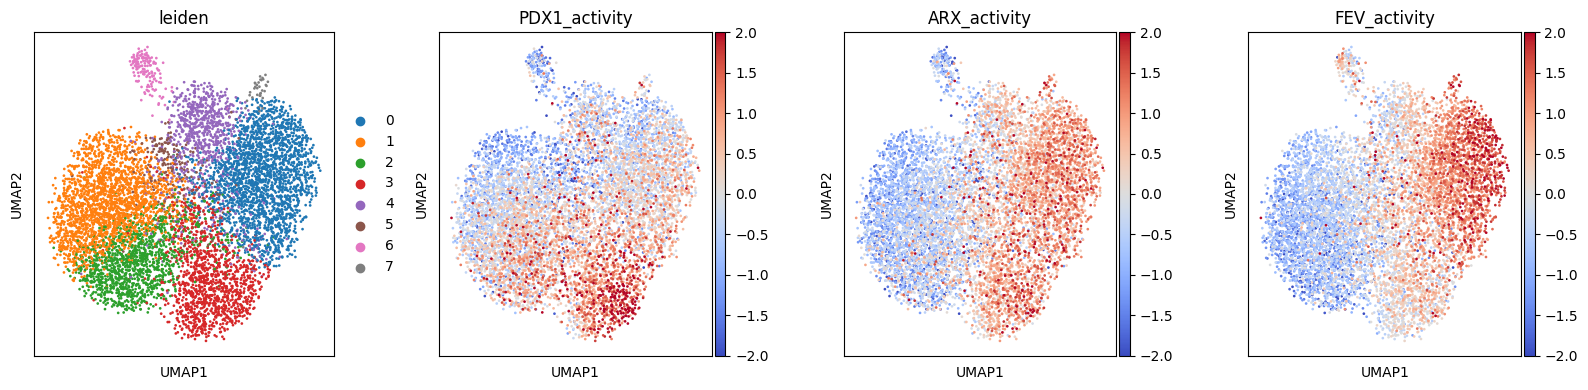

In [36]:
f, axs = plt.subplots(ncols=4, figsize=(16, 4))
sc.pl.umap(ad, color='leiden', ax=axs[0], show=False)
sc.pl.umap(ad, color='PDX1_activity', ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(ad, color='ARX_activity', ax=axs[2], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(ad, color='FEV_activity', ax=axs[3], cmap='coolwarm', vmin=-2, vmax=2,show=False)
f.tight_layout()

# DONE!

---